In [77]:
# Import Liberies

In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report
import tensorflow as tf



2024-03-12 22:02:24.903302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


OSError: No file or directory found at my_model.keras

In [79]:
# Data Preparation

In [80]:
# Define the path to the training data and testing data
file_path = "train"
file_path1 = "test"

In [81]:
# Obtain the class names from the training and testing directory
name_class = os.listdir(file_path)
name_class1 = os.listdir(file_path1)

In [82]:
# Create a list of file paths for all images in the training and testing directory
file_paths = list(glob.glob(file_path+'/**/*.*'))
file_paths1 = list(glob.glob(file_path1+'/**/*.*'))

In [83]:
# Extract labels from file paths using directory structure
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))
labels1 = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths1))

In [84]:
# Create Pandas Series for file paths and labels
# Combine file paths and labels into a Pandas dataframe and shuffle the data
filepath = pd.Series(file_paths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath,labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,train/malignant/melanoma_7245.jpg,malignant
1,train/malignant/melanoma_6743.jpg,malignant
2,train/benign/melanoma_2906.jpg,benign
3,train/benign/melanoma_1188.jpg,benign
4,train/benign/melanoma_4888.jpg,benign


In [85]:
# Create Pandas Series for file paths and labels
# Combine file paths and labels into a Pandas dataframe and shuffle the data
filepath1 = pd.Series(file_paths1, name='Filepath').astype(str)
labels1 = pd.Series(labels1, name='Label')
data1 = pd.concat([filepath1,labels1], axis=1)
data1 = data1.sample(frac=1).reset_index(drop=True)
data1.head(5)

,Filepath,Label
0,test/malignant/melanoma_10126.jpg,malignant
1,test/malignant/melanoma_10158.jpg,malignant
2,test/malignant/melanoma_10505.jpg,malignant
3,test/benign/melanoma_9822.jpg,benign
4,test/benign/melanoma_9831.jpg,benign


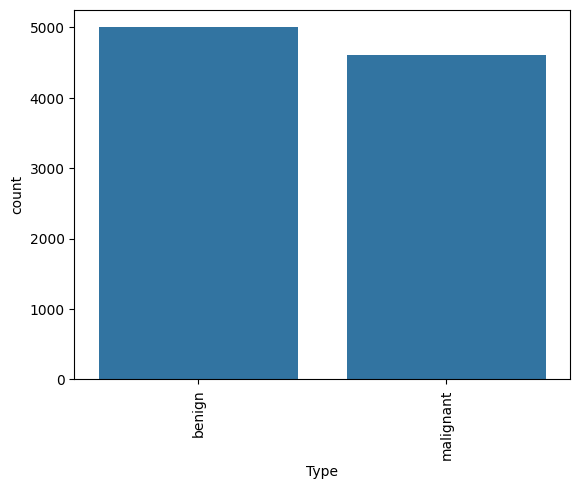

In [86]:
# Visualize the distribution of classes and display a grid of training images
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

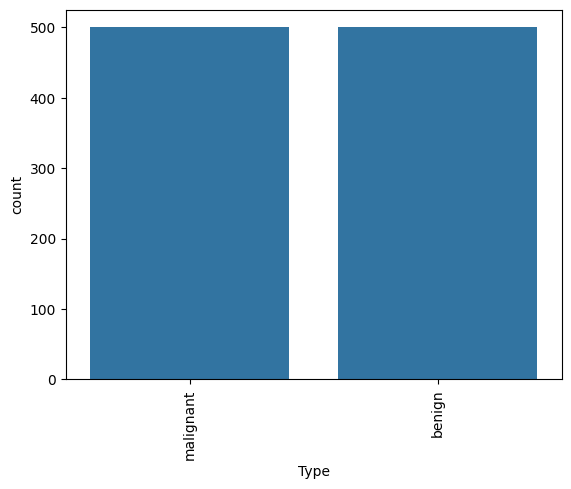

In [87]:
# Visualize the distribution of classes and display a grid of testing images
counts = data1.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

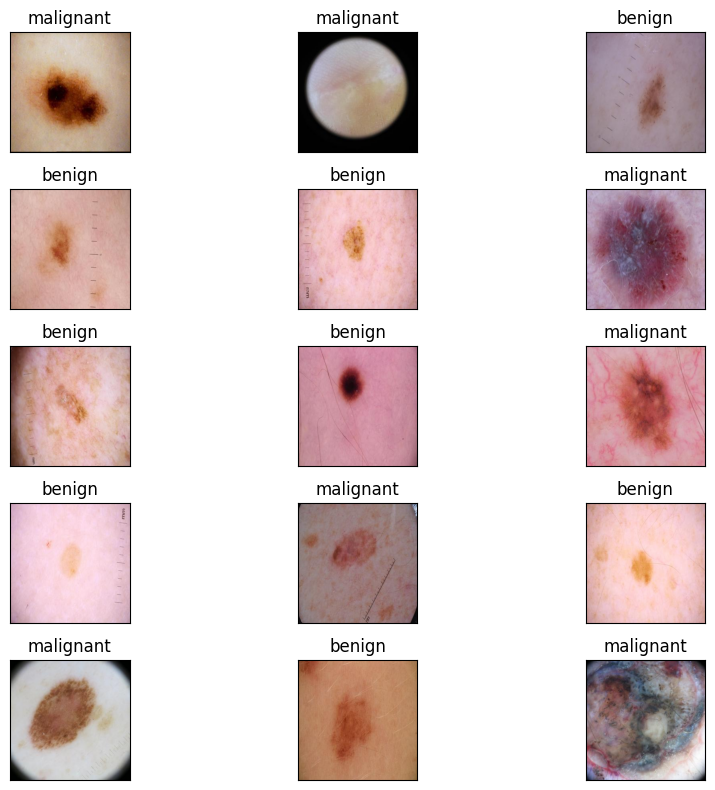

In [88]:
# Visualize the distribution of classes and display a grid of training images
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

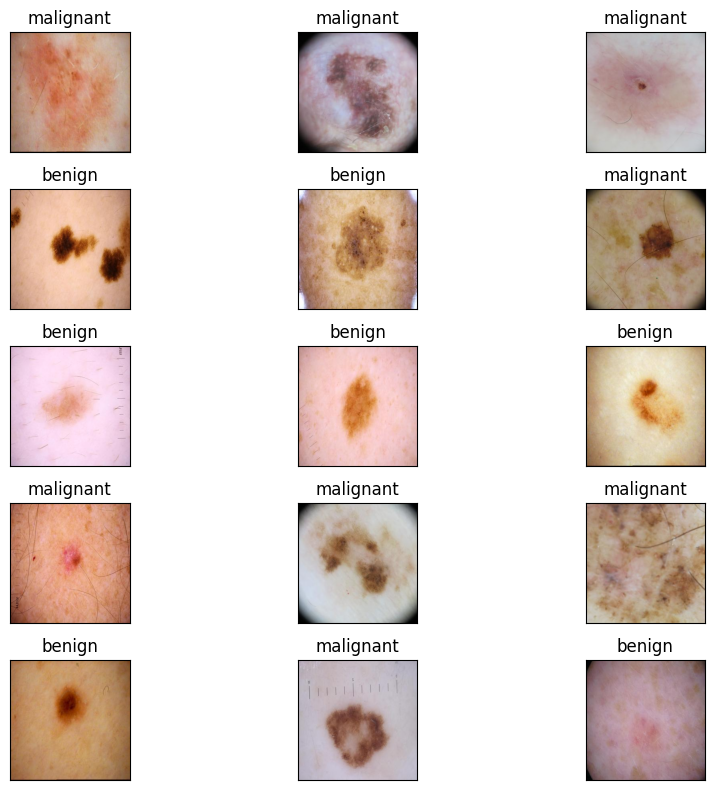

In [89]:
# Visualize the distribution of classes and display a grid of testing images
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data1.Filepath[i]))
    ax.set_title(data1.Label[i])
plt.tight_layout()
plt.show()

In [90]:
# Data Augmentation

In [91]:
# Store the prepared training and testing datasets
train = data
test = data1
# Create instances of ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [92]:
# Set up flow generators for training, validation, and testing data
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42   
)


valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42   
)


test_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False 
)

Found 9605 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [93]:
# Model Definition

In [94]:
# Load a pre-trained ResNet50 model for transfer learning
pretrained_model = ResNet50(
    input_shape=(100,100,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
# Freeze the weights of the pre-trained layers
pretrained_model.trainable = False

In [95]:
# Add custom dense layers for classification on top of the ResNet50 base
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Define your learning rate
learning_rate = 0.001  # You can adjust this value as needed

# Create Adam optimizer with custom learning rate
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [96]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [97]:
# Implement early stopping during training
my_callbacks = [EarlyStopping(monitor='val_accuracy',
                min_delta=0,
                patience=2,
                mode='auto')]

In [98]:
# Model Training

In [99]:

# Train the model on the training data
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100
)

Epoch 1/25
301/301 [==============================] - 157s 511ms/step - loss: 0.2516 - accuracy: 0.8934 - val_loss: 0.2448 - val_accuracy: 0.9060
Epoch 2/25
301/301 [==============================] - 160s 532ms/step - loss: 0.1935 - accuracy: 0.9230 - val_loss: 0.2120 - val_accuracy: 0.9160
Epoch 3/25
301/301 [==============================] - 163s 541ms/step - loss: 0.1654 - accuracy: 0.9345 - val_loss: 0.2255 - val_accuracy: 0.9060
Epoch 4/25
301/301 [==============================] - 167s 555ms/step - loss: 0.1411 - accuracy: 0.9433 - val_loss: 0.2210 - val_accuracy: 0.9070
Epoch 5/25
301/301 [==============================] - 179s 594ms/step - loss: 0.1266 - accuracy: 0.9488 - val_loss: 0.2263 - val_accuracy: 0.9180
Epoch 6/25
301/301 [==============================] - 507s 2s/step - loss: 0.1145 - accuracy: 0.9555 - val_loss: 0.2405 - val_accuracy: 0.9080
Epoch 7/25
301/301 [==============================] - 194s 644ms/step - loss: 0.0984 - accuracy: 0.9606 - val_loss: 0.2557 - va

In [100]:
model.save('my_model.keras')

In [101]:
# Model Evaluation and Visualization

In [ ]:
from tensorflow.keras.models import load_model
loaded_model_imageNet = load_model('my_model.keras')
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

import cv2 
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input


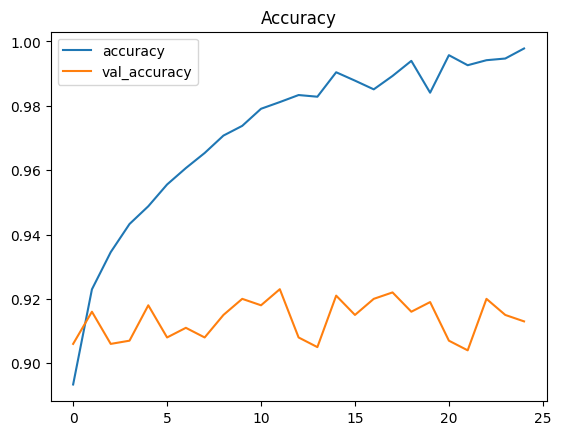

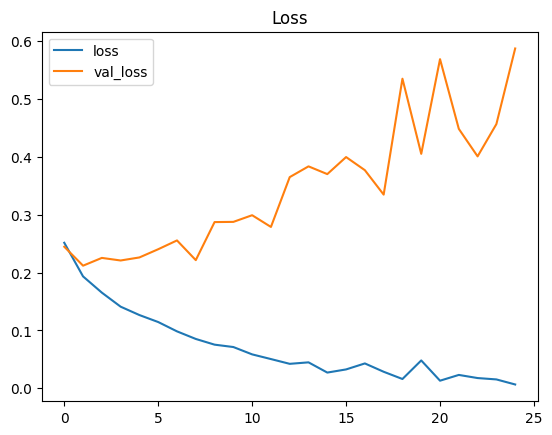

In [102]:
# Plot training and validation accuracy over epochs
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title('Accuracy')
plt.show()
# Plot training and validation loss over epochs
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

In [103]:
# Evaluate the model on the test set
results = model.evaluate(test_gen, verbose=0)
# Print test loss and accuracy
print(" Test Loss: {: .5f}".format(results[0]))
print(" Test Accuracy: {: .2f}%".format(results[1]*100))

 Test Loss:  0.58764
 Test Accuracy:  91.30%


In [104]:
# Make predictions on the test set and print a classification report
pred = model.predict(test_gen)
pred = np.argmax(pred, axis=1)

labels = (train_gen.class_indices)
labels = dict((v,k)for k,v in labels.items())
pred =[labels[k] for k in pred]

y_test = list(test.Label)
print(classification_report(y_test, pred))


32/32 [==============================] - 19s 559ms/step
              precision    recall  f1-score   support

      benign       0.90      0.92      0.91       500
   malignant       0.92      0.90      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



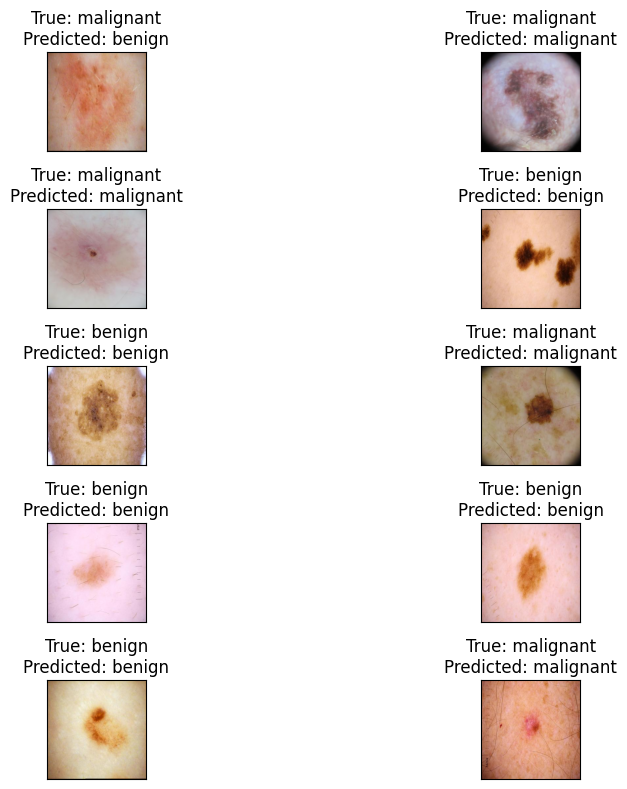

In [105]:
# Visualize predictions on a grid of images from the test set
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                         subplot_kw={"xticks": [], "yticks": []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()



In [106]:
# Prediction on a Single Image

1/1 [==============================] - 2s 2s/step
[[99  0]]


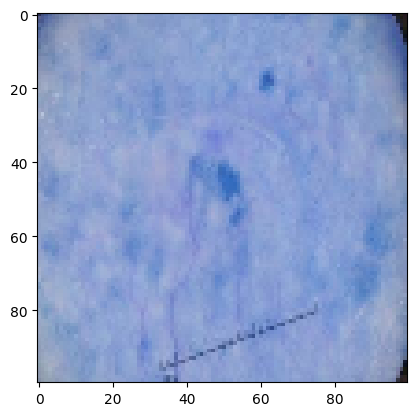

In [107]:
# Example of predicting on a new image
img_path = "melanoma_9914.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (100,100))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
result = loaded_model_imageNet.predict(x)
print((result*100).astype("int"))
plt.imshow(img)

In [108]:
p = list((result*100).astype('int'))
pp = list(p[0])
print(pp)
print("Larget element is:", max(pp))

[99, 0]
Larget element is: 99


In [109]:
index = pp.index(max(pp))
name_class=['benign','melignant']
name_class[index]

'benign'

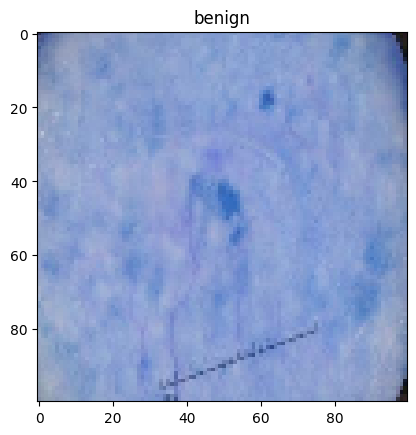

In [112]:
plt.title(name_class[index])
plt.imshow(img)